Zelle ausführen: _SHIFT + ENTER_
<br>
Neue Zelle einfügen: _Esc_ (dann ist ein blauer Rand um die Zelle), dann _a_ (above) oder _b_ (below)

In [1]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from pathlib import Path
#import os

Funktionen

In [ ]:
def find_time (row):
    return row["valid"].split(" ")[-1]

def find_day (row):
    return int(row["valid"].split("-")[2].split(" ")[0])

def find_month (row):
    return int(row["valid"].split("-")[1])

def find_year (row):
    return int(row["valid"].split("-")[0])

def initialize_dataset_from_location(original_dataset):
    """
    Get the raw data and adjust is to our purposes.
    
    original_dataset: pandas table
        downloaded from IOWA state university website
    """
    
    # copy the dataset to a new one
    modified_dataset = original_dataset
    
    # delete unnecessary columns
    del modified_dataset["ice_accretion_1hr"]
    del modified_dataset["ice_accretion_3hr"]
    del modified_dataset["ice_accretion_6hr"]
    
    del modified_dataset["peak_wind_gust"]
    del modified_dataset["peak_wind_drct"]
    del modified_dataset["peak_wind_time"] 
    
    del modified_dataset["skyl1"]
    del modified_dataset["skyl2"]
    del modified_dataset["skyl3"]
    del modified_dataset["skyl4"]
    
    del modified_dataset["skyc1"]
    del modified_dataset["skyc2"]
    del modified_dataset["skyc3"]
    del modified_dataset["skyc4"]
    del modified_dataset["wxcodes"]
    del modified_dataset["gust"]
    del modified_dataset["metar"]
    del modified_dataset["mslp"]
    del modified_dataset["elevation"]
    
    
    # append colums for easier filtering by day, month, year, time
    modified_dataset["time"] = original_dataset.apply (lambda row: find_time(row), axis=1)
    modified_dataset["date"] = original_dataset.apply (lambda row: find_day(row), axis=1)
    modified_dataset["month"] = original_dataset.apply (lambda row: find_month(row), axis=1)
    modified_dataset["year"] = original_dataset.apply (lambda row: find_year(row), axis=1)
    
    # delete the rows where there are invalid entries in the temperature range
    modified_dataset = modified_dataset.drop(modified_dataset[modified_dataset["tmpf"] == "M"].index)
    
    return modified_dataset

Einlesen und "Brauchbarmachen" der Rohdaten

In [121]:
# path to dataset 
path_to_table = r"C:\Users\Anja\Downloads\Westerland.txt"

In [127]:
raw_data_westerland = pd.read_csv(path_to_table, low_memory = False)

In [126]:
data_westerland = initialize_dataset_from_location(raw_data_westerland)

NameError: name 'raw_data_westerland' is not defined

In [125]:
# take a look at your dataset

#station: three or four character site identifier
#valid: timestamp of the observation
#tmpf: Air Temperature in Fahrenheit, typically @ 2 meters
#dwpf: Dew Point Temperature in Fahrenheit, typically @ 2 meters
#relh: Relative Humidity in %
#drct: Wind Direction in degrees from *true* north
#sknt: Wind Speed in knots
#alti: Pressure altimeter in inches
#vsby: Visibility in miles
#feel: Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit

data_westerland

Temperaturen in °C angeben 

In [119]:
# calculate temperature in celcius
# T(°C) = (T(°F) - 32) × 5/9

# create a new column named "tmpc"
# use the "tmpf" column and perform the calculation


data_westerland["tmpc"] = (data_westerland["tmpf"] - 32) * 5/9

## this does not work! why?!

In [ ]:
## you need to convert the column to "float" data value
#data_westerland["tmpc"] = (data_westerland["tmpf"].astype("float") - 32) * 5/9

Jetzt geht es an die ersten Plots!

In [29]:
# select data points from one month, one point in time
year = 2011
month = 9
time = "10:20"

# create a subset in which you only select specific entries
data_subset = data_westerland[data_westerland['year'] == year]
data_subset = data_subset[data_subset['month'] == month]
data_subset = data_subset[data_subset['time'] == time]

In [30]:
# display the subset
data_subset

,Unnamed: 0,station,valid,lon,lat,elevation,tmpf,dwpf,relh,drct,sknt,alti,vsby,feel,time,month,year,date,tmpc
5473,5473,EDXW,2011-09-01 10:20,8.3405,54.9132,20.0,59.00,48.20,67.33,340.00,10.00,29.97,6.21,59.00,10:20,9,2011,1,15.0
5521,5521,EDXW,2011-09-02 10:20,8.3405,54.9132,20.0,60.80,50.00,67.54,190.00,12.00,29.94,6.21,60.80,10:20,9,2011,2,16.0
5569,5569,EDXW,2011-09-03 10:20,8.3405,54.9132,20.0,62.60,60.80,93.83,200.00,5.00,29.88,0.81,62.60,10:20,9,2011,3,17.0
5617,5617,EDXW,2011-09-04 10:20,8.3405,54.9132,20.0,66.20,62.60,88.18,190.00,7.00,29.74,6.21,66.20,10:20,9,2011,4,19.0
5665,5665,EDXW,2011-09-05 10:20,8.3405,54.9132,20.0,66.20,57.20,72.74,230.00,15.00,29.77,6.21,66.20,10:20,9,2011,5,19.0
5721,5721,EDXW,2011-09-06 10:20,8.3405,54.9132,20.0,60.80,55.40,82.37,200.00,24.00,29.74,6.21,60.80,10:20,9,2011,6,16.0
5768,5768,EDXW,2011-09-07 10:20,8.3405,54.9132,20.0,59.00,50.00,72.01,280.00,26.00,29.50,6.21,59.00,10:20,9,2011,7,15.0
5815,5815,EDXW,2011-09-08 10:20,8.3405,54.9132,20.0,57.20,50.00,76.82,270.00,17.00,29.56,6.21,57.20,10:20,9,2011,8,14.0
5863,5863,EDXW,2011-09-09 10:20,8.3405,54.9132,20.0,59.00,48.20,67.33,230.00,6.00,29.80,6.21,59.00,10:20,9,2011,9,15.0
5911,5911,EDXW,2011-09-10 10:20,8.3405,54.9132,20.0,62.60,60.80,93.83,200.00,11.00,29.83,3.11,62.60,10:20,9,2011,10,17.0


In [ ]:
# define what you want to plot as x and y
# this step is actually not necessary, we will use it for clarification
x = data_subset["date"] 
y_f = data_subset["tmpf"]
y_c = data_subset["tmpc"]

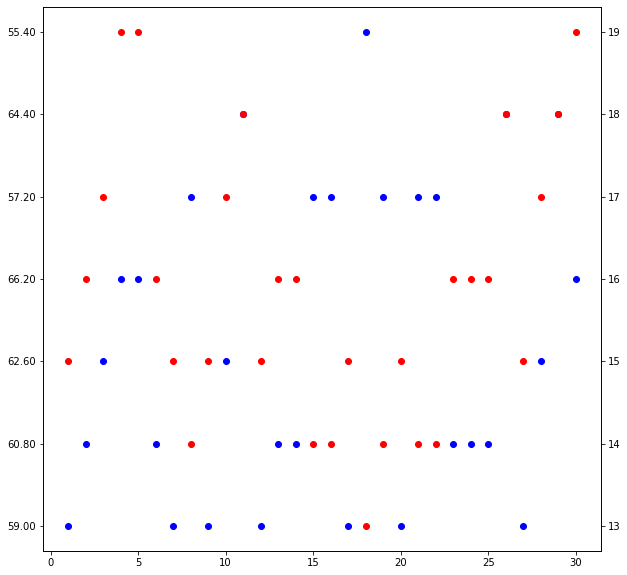

In [34]:
# create the figure where the plot shall appear and define its size
plt.figure(figsize = [10,10])

# tell the program that you want to have one plot inside the figure
# name your plot "ax1"
ax1 = plt.subplot(1,1,1)
# tell the program what you want to plot inside of "ax1": x and y_f
# tell the program more details about how to plot it (blue filled circles) - e.g. "y+" creates yellow crosses
ax1.plot(x, y_f, "bo")

# create an axis at the left hand side of the graph that has the same x-axis as "ax1" (i.e. twin x-axis)
ax2 = ax1.twinx()
# tell the program what you want to see on the second y-axis
ax2.plot(x, y_c, "ro")

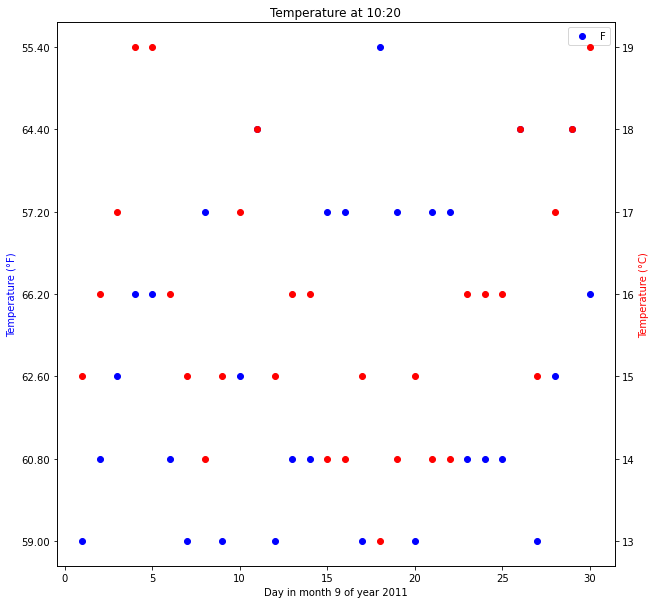

In [39]:
# create the figure where the plot shall appear and define its size
plt.figure(figsize = [10,10])

# tell the program that you want to have one plot inside the figure
# name your plot "ax1"
ax1 = plt.subplot(1,1,1)
# tell the program what you want to plot inside of "ax1": x and y_f
# tell the program more details about how to plot it (blue filled circles) - e.g. "y+" creates yellow crosses
ax1.plot(x, y_f, "bo", label = "F")

# create an axis at the left hand side of the graph that has the same x-axis as "ax1" (i.e. twin x-axis)
ax2 = ax1.twinx()
# tell the program what you want to see on the second y-axis
ax2.plot(x, y_c, "ro", label = "C")


### add more information to your plot

# label your axes
ax1.set_xlabel("Day in month " + str(month) + " of year " + str(year))
ax1.set_ylabel("Temperature (°F)", color = "b")
ax2.set_ylabel("Temperature (°C)", color = "r")

# create title
ax1.set_title("Temperature at " + time)


Nachdem wir uns jetzt gemeinsam ein paar Dinge angeschaut haben, hier Aufgaben für dich. Du kannst dir aussuchen, welche du bearbeiten möchtest. Programmieren lebt vom **Ausprobieren** und hier in den Notebooks kannst du nichts kaputt machen. 
<br>
Wenn du nicht weiterkommst - versuche mal, dein Problem so zu formulieren, dass du es in deiner **Suchmaschine eingeben** kannst (englisch, wahlweise deutsch) und es dann zu suchen. Antworten auf die aller(aller)meisten Fragen finden sich nämlich schon da.

In [18]:
# make your own plot!
# compare the temperature (in °C) in the morning and evening in westerland for September 2016

##### you can follow the subsequent step-by-step suggestions

# create a new figure and subplot

# define the data you want to display

# plot them on the same y-axis (no need for twinning as we only look at one temperature scale)
# get creative with color (e.g. r, b, g, y, k, ..) and linestlye (e.g. dots (o), line (-), crosses (+), ..)

### add more information on your plot 
 
# label the x-axis

# label the y-axis

# create a title

# implement a legend for your plot
# ax1.legend()

5473    59.00
5521    60.80
5569    62.60
5617    66.20
5665    66.20
5721    60.80
5768    59.00
5815    57.20
5863    59.00
5911    62.60
5958    64.40
6006    59.00
6054    60.80
6101    60.80
6149    57.20
6199    57.20
6249    59.00
6299    55.40
6347    57.20
6395    59.00
6445    57.20
6493    57.20
6541    60.80
6589    60.80
6637    60.80
6685    64.40
6733    59.00
6781    62.60
6829    64.40
6877    66.20
Name: tmpf, dtype: object

In [ ]:
# do calculations
# calculate the average day temperature (in °C) in Westerland

##### you can follow the subsequent step-by-step suggestions

# create a new table where you want to save the data
# you need the following entries: year - month - day - avg temp

daily_avg_westerland = new table w label (time) (tavgc)

# calculate the entries from your data_westerland table

# create chunks with the same date

# calculate average: sum all temperatures and divide by number of entries

# transfer result into new table 
daily_avg_westerland["time"] = str(year) + "-" str(month) + "-" + str(day)
daily_avg_westerland["tavgc"] = avg_temp

# repeat for each chunk


In [ ]:
# (optional) plot your result

In [ ]:
# do calculations
# calculate the average temperature (in °C) per month in Westerland

##### modify the above code to calculate not daily averages but monthly averages 
# tip you can use your daily_avg caluclations for this

In [ ]:
# now we add a new dataset from Georgetown

# compare the average daily temperature (in °C) in the year 2012 from Westerland to Georgetown by plotting them
# where is Georgetown?

#### to do this, you will to repeat nearly all the above steps to manipulate the raw data set! 
## you can do it!

In [ ]:
# define functions
# if you want to repeat a certain operation multiple times (e.g. on different datasets), you make a function
# calling the function will execute your script -- see example below

# new_table = create_table_of_daily_avgs(dataset_from_location)

# if you want to do this - let's do it